In [ ]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
#model and 
from utils import *
X,labels=read_data('datasets/data sets/MSRC-v1.mat')
X = [X[0,i].T for  i  in range(X.shape[1])]
labels  = labels.squeeze()
from models import MSE
model_MSE = MSE()

res = []
for d_ in range(10,20):
    Y = model_MSE.mse(X,gamma = 0.9,d_=d_,t=1e8,epoch=500)

    nmi_list = []
    for i in range(50):
        pred = kmeans(Y,7)
        # criterion
        from sklearn.metrics.cluster import normalized_mutual_info_score
        nmi = normalized_mutual_info_score(labels,pred)
        nmi_list.append(nmi)
    nmi = np.mean(nmi_list)
    res.append(nmi)
import matplotlib.pyplot as plt


In [43]:
# x=np.random.rand(3,4)
# np.identity(x.shape[1])-1/x.shape[1]
for i in list(range(10))+list(range(11,13)):
    print(i)

0
1
2
3
4
5
6
7
8
9
11
12


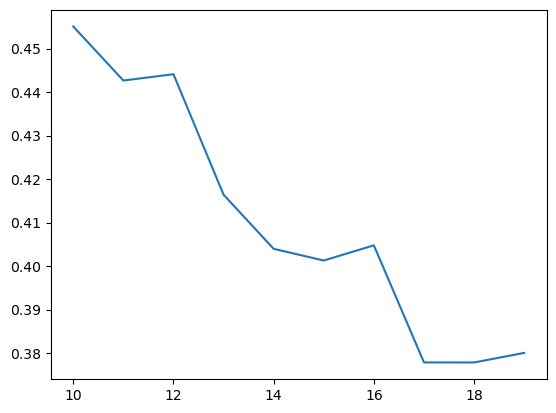

In [33]:
plt.plot(range(10,20),res)